In [2]:
"""
I needed to install pyprotocols, which needed git clone https://github.com/pdollar/coco.git
to be cloned and "make" the pythonapi, which needed make to be installed, which needed apt-get update
check https://github.com/cocodataset/cocoapi/issues/8
and https://askubuntu.com/questions/192645/make-command-not-found
"""
from gluoncv import data, utils
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import random 
from skimage.transform import resize
import os 
random.seed = 11


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
image_list_dir = "/srv/workspace/research/mlml/datasets/nuswide/imagelist/ImageList/Imagelist.txt"
labels_dir = "/srv/workspace/research/mlml/datasets/nuswide/tags/AllTags81.txt"
labels_names_dir = "/srv/workspace/research/mlml/datasets/nuswide/tags/Concepts81.txt"
images_list = pd.read_csv(image_list_dir, sep=" ", header=None)
labels = pd.read_csv(labels_dir,delim_whitespace = True, header=None)
LABELS_LIST =  [line.rstrip('\n') for line in open(labels_names_dir)]

In [19]:
labels.index = images_list.iloc[:,0]
labels.index = [w.replace('\\', '/') for w in labels.index]
labels = labels[labels.sum(axis=1) >= 3]

In [20]:
def nuswide_labels_idx_to_names(labels,labelnames = LABELS_LIST):
    return labelnames[np.where(labels == 1)[0]]

In [5]:
images_raw_dir = '/srv/workspace/research/mlml/datasets/nuswide/Flickr/'
testimage = os.path.join(images_raw_dir,labels.index[0])

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(testimage)

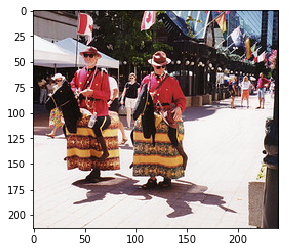

In [7]:
plt.imshow(img)

In [8]:
nuswide_labels_idx_to_names(labels.iloc[0,:])

TypeError: only integer scalar arrays can be converted to a scalar index

In [46]:
INPUT_SHAPE = (224, 224, 3)
INPUT_IMAGE_MEAN = [0.485, 0.456, 0.406]
INPUT_IMAGE_STD = [0.229, 0.224, 0.225]
SAVE_DIRECTORY = "/srv/workspace/research/mlml/datasets/nuswide/image_formatted_npz/"
images_raw_dir = '/srv/workspace/research/mlml/datasets/nuswide/Flickr/'

counter = 0
for image_idx in labels.index:
    try:
        image = mpimg.imread(os.path.join(images_raw_dir,image_idx))
        #image = image.asnumpy()
        image = image.astype(np.float32)
        image /= 255.0
        image = (image - INPUT_IMAGE_MEAN) / INPUT_IMAGE_STD
        image = resize(image, INPUT_SHAPE)
        image = image.astype(np.float32)
        name = image_idx.split('/')[1].split('.')[0]
        np.savez(SAVE_DIRECTORY+name, image = image)
    except: 
        continue
    counter += 1
    if counter%500 == 0:
        print(counter)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500


In [21]:
labels.index = [image_idx.split('/')[1].split('.')[0] for image_idx in labels.index]

In [7]:
labels.reset_index(level=0,inplace=True)

In [49]:
labels.to_csv('/srv/workspace/research/mlml/datasets/nuswide/labels_4min.csv')

In [50]:
from skmultilearn.model_selection import iterative_train_test_split


SAVE_DIRECTORY = '/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_nus/'
global_labels = pd.read_csv('/srv/workspace/research/mlml/datasets/nuswide/labels_4min.csv')
global_labels.drop(["Unnamed: 0"],axis=1, inplace= True)
global_labels = global_labels.set_index("index")

#select only images with more than 4 labels
#global_labels = global_labels[global_labels.sum(axis=1) >= 4]
labels_array = global_labels.values

#making splits
train_indices = np.asarray([global_labels.index.values]*2).T # duplicating the column because iterative splits expects >1 dim
# create two splits
X_half1, y_half1, X_half2, y_half2 = iterative_train_test_split(train_indices, labels_array, test_size = 0.5)
# split each split to two splits
X_quarter1, y_quarter1, X_quarter2, y_quarter2 = iterative_train_test_split(X_half1, y_half1, test_size = 0.5)
X_quarter3, y_quarter3, X_quarter4, y_quarter4 = iterative_train_test_split(X_half2, y_half2, test_size = 0.5)      
split1 = pd.DataFrame(y_quarter1, columns=global_labels.columns, index = X_quarter1[:,0])
split2 = pd.DataFrame(y_quarter2, columns=global_labels.columns, index = X_quarter2[:,0])
split3 = pd.DataFrame(y_quarter3, columns=global_labels.columns, index = X_quarter3[:,0])
split4 = pd.DataFrame(y_quarter4, columns=global_labels.columns, index = X_quarter4[:,0])
train1 = pd.concat([split1,split2,split3])
test1 = split4
train2 = pd.concat([split1,split2,split4])
test2 = split3
train3 = pd.concat([split1,split3,split4])
test3 = split2
train4 = pd.concat([split2,split3,split4])
test4 = split1

In [51]:
def hide_labels_per_sample(train_labels,ratio_of_hidden_samples = 0.4):
    number_of_labels_to_hide_per_sample = np.round(np.sum(train_labels,axis=1)*ratio_of_hidden_samples)
    train_negative_weights = np.zeros_like(train_labels) + 1 
    labels_with_missing_positives = np.copy(train_labels)
    for idx, sample in enumerate(labels_array):
        indices_to_hide = random.sample(list(np.nonzero(sample)[0]),int(number_of_labels_to_hide_per_sample[idx]))
        labels_with_missing_positives[idx][indices_to_hide] = 0 
        train_negative_weights[idx][indices_to_hide] = 0 
    return labels_with_missing_positives, train_negative_weights


def get_positive_weights(train_labels, pos_weights = 1):
    train_positive_weights = np.zeros_like(train_labels) + pos_weights # We make positive weight 5 becuase of data imbalance
    return train_positive_weights


In [52]:
ratios_to_hide = np.arange(0,1,0.25)
for ratio in ratios_to_hide:
    ratio_save_dir = os.path.join(SAVE_DIRECTORY,'missing_labels'+str(round(ratio, 1)))
    os.makedirs(ratio_save_dir,exist_ok=True)
    # Split1
    labels_array = train1.values
    labels_with_missing_positives, train_negative_weights = hide_labels_per_sample(labels_array,ratio)
    labels_with_missing_positives_df = train1.copy() 
    labels_with_missing_positives_df.iloc[:,:] = labels_with_missing_positives
    labels_with_missing_positives_df.to_csv(os.path.join(ratio_save_dir,
                                                        'train1_'+str(round(ratio, 1))+'.csv'))
    
    train_negative_weights_df = train1.copy()
    train_negative_weights_df.iloc[:,:]=train_negative_weights
    train_negative_weights_df.to_csv(os.path.join(ratio_save_dir,'negative_weights1_'+str(round(ratio, 1))+'.csv'))
    
    train_positive_weights = get_positive_weights(labels_with_missing_positives)
    train_positive_weights_df = train1.copy()
    train_positive_weights_df.iloc[:,:]=train_positive_weights
    train_positive_weights_df.to_csv(os.path.join(ratio_save_dir,'positive_weights'+str(round(ratio, 1))+'.csv'),
                                                        index = False)
    
    test1.to_csv(os.path.join(ratio_save_dir,'test1_'+str(round(ratio, 1))+'.csv'))  
    
    
    # Split2
    labels_array = train2.values
    labels_with_missing_positives, train_negative_weights = hide_labels_per_sample(labels_array,ratio)
    labels_with_missing_positives_df = train2.copy() 
    labels_with_missing_positives_df.iloc[:,:] = labels_with_missing_positives
    labels_with_missing_positives_df.to_csv(os.path.join(ratio_save_dir,
                                                        'train2_'+str(round(ratio, 1))+'.csv'))
    
    train_negative_weights_df = train2.copy()
    train_negative_weights_df.iloc[:,:]=train_negative_weights
    train_negative_weights_df.to_csv(os.path.join(ratio_save_dir,'negative_weights2_'+str(round(ratio, 1))+'.csv'))
    
    train_positive_weights = get_positive_weights(labels_with_missing_positives)
    train_positive_weights_df = train2.copy()
    train_positive_weights_df.iloc[:,:]=train_positive_weights
    train_positive_weights_df.to_csv(os.path.join(ratio_save_dir,'positive_weights'+str(round(ratio, 1))+'.csv'),
                                                        index = False)
    
    test2.to_csv(os.path.join(ratio_save_dir,'test2_'+str(round(ratio, 1))+'.csv'))  
    
    # Split3
    labels_array = train3.values
    labels_with_missing_positives, train_negative_weights = hide_labels_per_sample(labels_array,ratio)
    labels_with_missing_positives_df = train3.copy() 
    labels_with_missing_positives_df.iloc[:,:] = labels_with_missing_positives
    labels_with_missing_positives_df.to_csv(os.path.join(ratio_save_dir,
                                                        'train3_'+str(round(ratio, 1))+'.csv'))
    
    train_negative_weights_df = train3.copy()
    train_negative_weights_df.iloc[:,:]=train_negative_weights
    train_negative_weights_df.to_csv(os.path.join(ratio_save_dir,'negative_weights3_'+str(round(ratio, 1))+'.csv'))
    
    train_positive_weights = get_positive_weights(labels_with_missing_positives)
    train_positive_weights_df = train3.copy()
    train_positive_weights_df.iloc[:,:]=train_positive_weights
    train_positive_weights_df.to_csv(os.path.join(ratio_save_dir,'positive_weights'+str(round(ratio, 1))+'.csv'),
                                                        index = False)
    
    test3.to_csv(os.path.join(ratio_save_dir,'test3_'+str(round(ratio, 1))+'.csv'))  

                                  
    # Split4
    labels_array = train4.values
    labels_with_missing_positives, train_negative_weights = hide_labels_per_sample(labels_array,ratio)
    labels_with_missing_positives_df = train4.copy() 
    labels_with_missing_positives_df.iloc[:,:] = labels_with_missing_positives
    labels_with_missing_positives_df.to_csv(os.path.join(ratio_save_dir,
                                                        'train4_'+str(round(ratio, 1))+'.csv'))
    
    train_negative_weights_df = train4.copy()
    train_negative_weights_df.iloc[:,:]=train_negative_weights
    train_negative_weights_df.to_csv(os.path.join(ratio_save_dir,'negative_weights4_'+str(round(ratio, 1))+'.csv'))
    
    train_positive_weights = get_positive_weights(labels_with_missing_positives)
    train_positive_weights_df = train4.copy()
    train_positive_weights_df.iloc[:,:]=train_positive_weights
    train_positive_weights_df.to_csv(os.path.join(ratio_save_dir,'positive_weights'+str(round(ratio, 1))+'.csv'),
                                                        index = False)
    
    test4.to_csv(os.path.join(ratio_save_dir,'test4_'+str(round(ratio, 1))+'.csv'))  

In [54]:
test4

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0041_2456602544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0090_1224483022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0229_433478352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0322_2093820806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0491_335496963,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
0034_509197470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0060_1322986287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0223_298872461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0250_51561578,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
0261_312203486,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
def negative_labeles_probabilities(hot_encoded):
    # count the number of times a combination has appeared with the negative label as 1 / the total number of
    # occurances of that combination without the negative label
    negative_weights = np.zeros([len(hot_encoded), len(LABELS_LIST)])
    for sample_idx in range(len(hot_encoded)):
        for label_idx in range(len(LABELS_LIST)):
            if hot_encoded.iloc[sample_idx, label_idx+1] == 1:
                negative_weights[sample_idx, label_idx] = 0
            else:
                temp_combination = hot_encoded.iloc[sample_idx,1:].copy()
                temp_combination[label_idx] = 1
                positive_samples = len(hot_encoded[(hot_encoded.iloc[:, 1:].values == temp_combination.values).all(axis = 1)])
                negative_samples = len(hot_encoded[(hot_encoded.iloc[:, 1:].values == hot_encoded.iloc[sample_idx, 1:].values).all(axis=1)])
                negative_weights[sample_idx, label_idx] = negative_samples / (positive_samples + negative_samples)
    negative_weights_df = pd.DataFrame(negative_weights, columns=LABELS_LIST)
    negative_weights_df["song_id"] = hot_encoded.song_id
    negative_weights_df = negative_weights_df[["song_id"] + LABELS_LIST]
    #negative_weights_df.to_csv("/home/karim/Documents/BalancedDatasetDeezer/GroundTruth/negative_weights.csv",index=False)
    return negative_weights_df


def negative_labeles_probabilities_ignoring_zeros(hot_encoded):
    # count the number of times a combination has appeared with the negative label as 1 / the total number of
    # occurances of that combination without the negative label
    negative_weights = np.zeros([len(hot_encoded), len(LABELS_LIST)])
    for sample_idx in range(len(hot_encoded)):
        for label_idx in range(len(LABELS_LIST)):
            if hot_encoded.iloc[sample_idx, label_idx+1] == 1:
                negative_weights[sample_idx, label_idx] = 0
            else:
                temp_combination = hot_encoded.iloc[sample_idx,1:].copy()
                temp_combination[label_idx] = 1
                # Compare only columns that are equal to 1, and count number of matches
                # adding one to skip the song_id column, which exists in the hot_encoded dataframe
                positive_columns = np.where(temp_combination.values == 1)[0] + 1
                positive_samples = len(hot_encoded[(hot_encoded.iloc[:, positive_columns].values == 1).all(axis = 1)])
                # Count occurances with the negative sample
                temp_combination[label_idx] = 0
                positive_columns = np.where(temp_combination.values == 1)[0] + 1
                total_occurances_of_pattern = len(hot_encoded[(hot_encoded.iloc[:, positive_columns].values == 1).all(axis = 1)])
                negative_weights[sample_idx, label_idx] = (total_occurances_of_pattern - positive_samples) / total_occurances_of_pattern
    negative_weights_df = pd.DataFrame(negative_weights, columns=LABELS_LIST)
    negative_weights_df["song_id"] = hot_encoded.song_id
    negative_weights_df = negative_weights_df[["song_id"] + LABELS_LIST]
    #negative_weights_df.to_csv("/home/karim/Documents/BalancedDatasetDeezer/GroundTruth/negative_weights.csv",index=False)
    return negative_weights_df


In [64]:
negative_weights = np.zeros([len(hot_encoded), len(LABELS_LIST)])
for sample_idx in range(len(hot_encoded)):
    for label_idx in range(len(LABELS_LIST)):
        if hot_encoded.iloc[sample_idx, label_idx+1] == 1:
            negative_weights[sample_idx, label_idx] = 0
        else:
            temp_combination = hot_encoded.iloc[sample_idx,1:].copy()
            temp_combination[label_idx] = 1
            # Compare only columns that are equal to 1, and count number of matches
            # adding one to skip the song_id column, which exists in the hot_encoded dataframe
            positive_columns = np.where(temp_combination.values == 1)[0] + 1
            positive_samples = len(hot_encoded[(hot_encoded.iloc[:, positive_columns].values == 1).all(axis = 1)])
            # Count occurances with the negative sample
            temp_combination[label_idx] = 0
            positive_columns = np.where(temp_combination.values == 1)[0] + 1
            total_occurances_of_pattern = len(hot_encoded[(hot_encoded.iloc[:, positive_columns].values == 1).all(axis = 1)])
            negative_weights[sample_idx, label_idx] = (total_occurances_of_pattern - positive_samples) / total_occurances_of_pattern
negative_weights_df = pd.DataFrame(negative_weights, columns=LABELS_LIST)
#negative_weights_df["song_id"] = hot_encoded.song_id
#negative_weights_df = negative_weights_df[["song_id"] + LABELS_LIST]

In [ ]:
negative_weights_df.index = global_labels.index

In [ ]:
negative_weights_df.to_csv(os.path.join('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/','negative_weights_global.csv'))

In [60]:
hot_encoded = global_labels.reset_index()

In [1]:
negative_weights.shape


NameError: name 'negative_weights' is not defined

In [24]:
# Check co-occurances between labels
def get_coocurances(labels_df, output_path = None):
    LABELS_LIST = labels_df.columns
    # Getting coocuarances
    coocurrances = pd.DataFrame(columns=labels_df.columns)
    coocurrances_normalized = pd.DataFrame(columns=labels_df.columns)
    for column in labels_df.columns:
        coocurrances[column] = labels_df[labels_df[column] == 1].sum()
        coocurrances_normalized[column] = labels_df[labels_df[column] == 1 ].sum()/labels_df[column].sum()
    coocurrances = coocurrances.T
    coocurrances_normalized = coocurrances_normalized.T
    coocurrances.values[[np.arange(coocurrances.shape[0])]*2] = 0
    # Plotting coocurances
    plt.figure(figsize=(30, 30));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'Number of track class coocurances', fontsize=34, ha='center')
    sn.heatmap(coocurrances, annot=False, annot_kws={"size": 24}, fmt='.0f', cmap=cmap);
    return coocurrances, coocurrances_normalized
    #plt.savefig(output_path + ".pdf", format="pdf")
    #plt.savefig(output_path + ".png")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


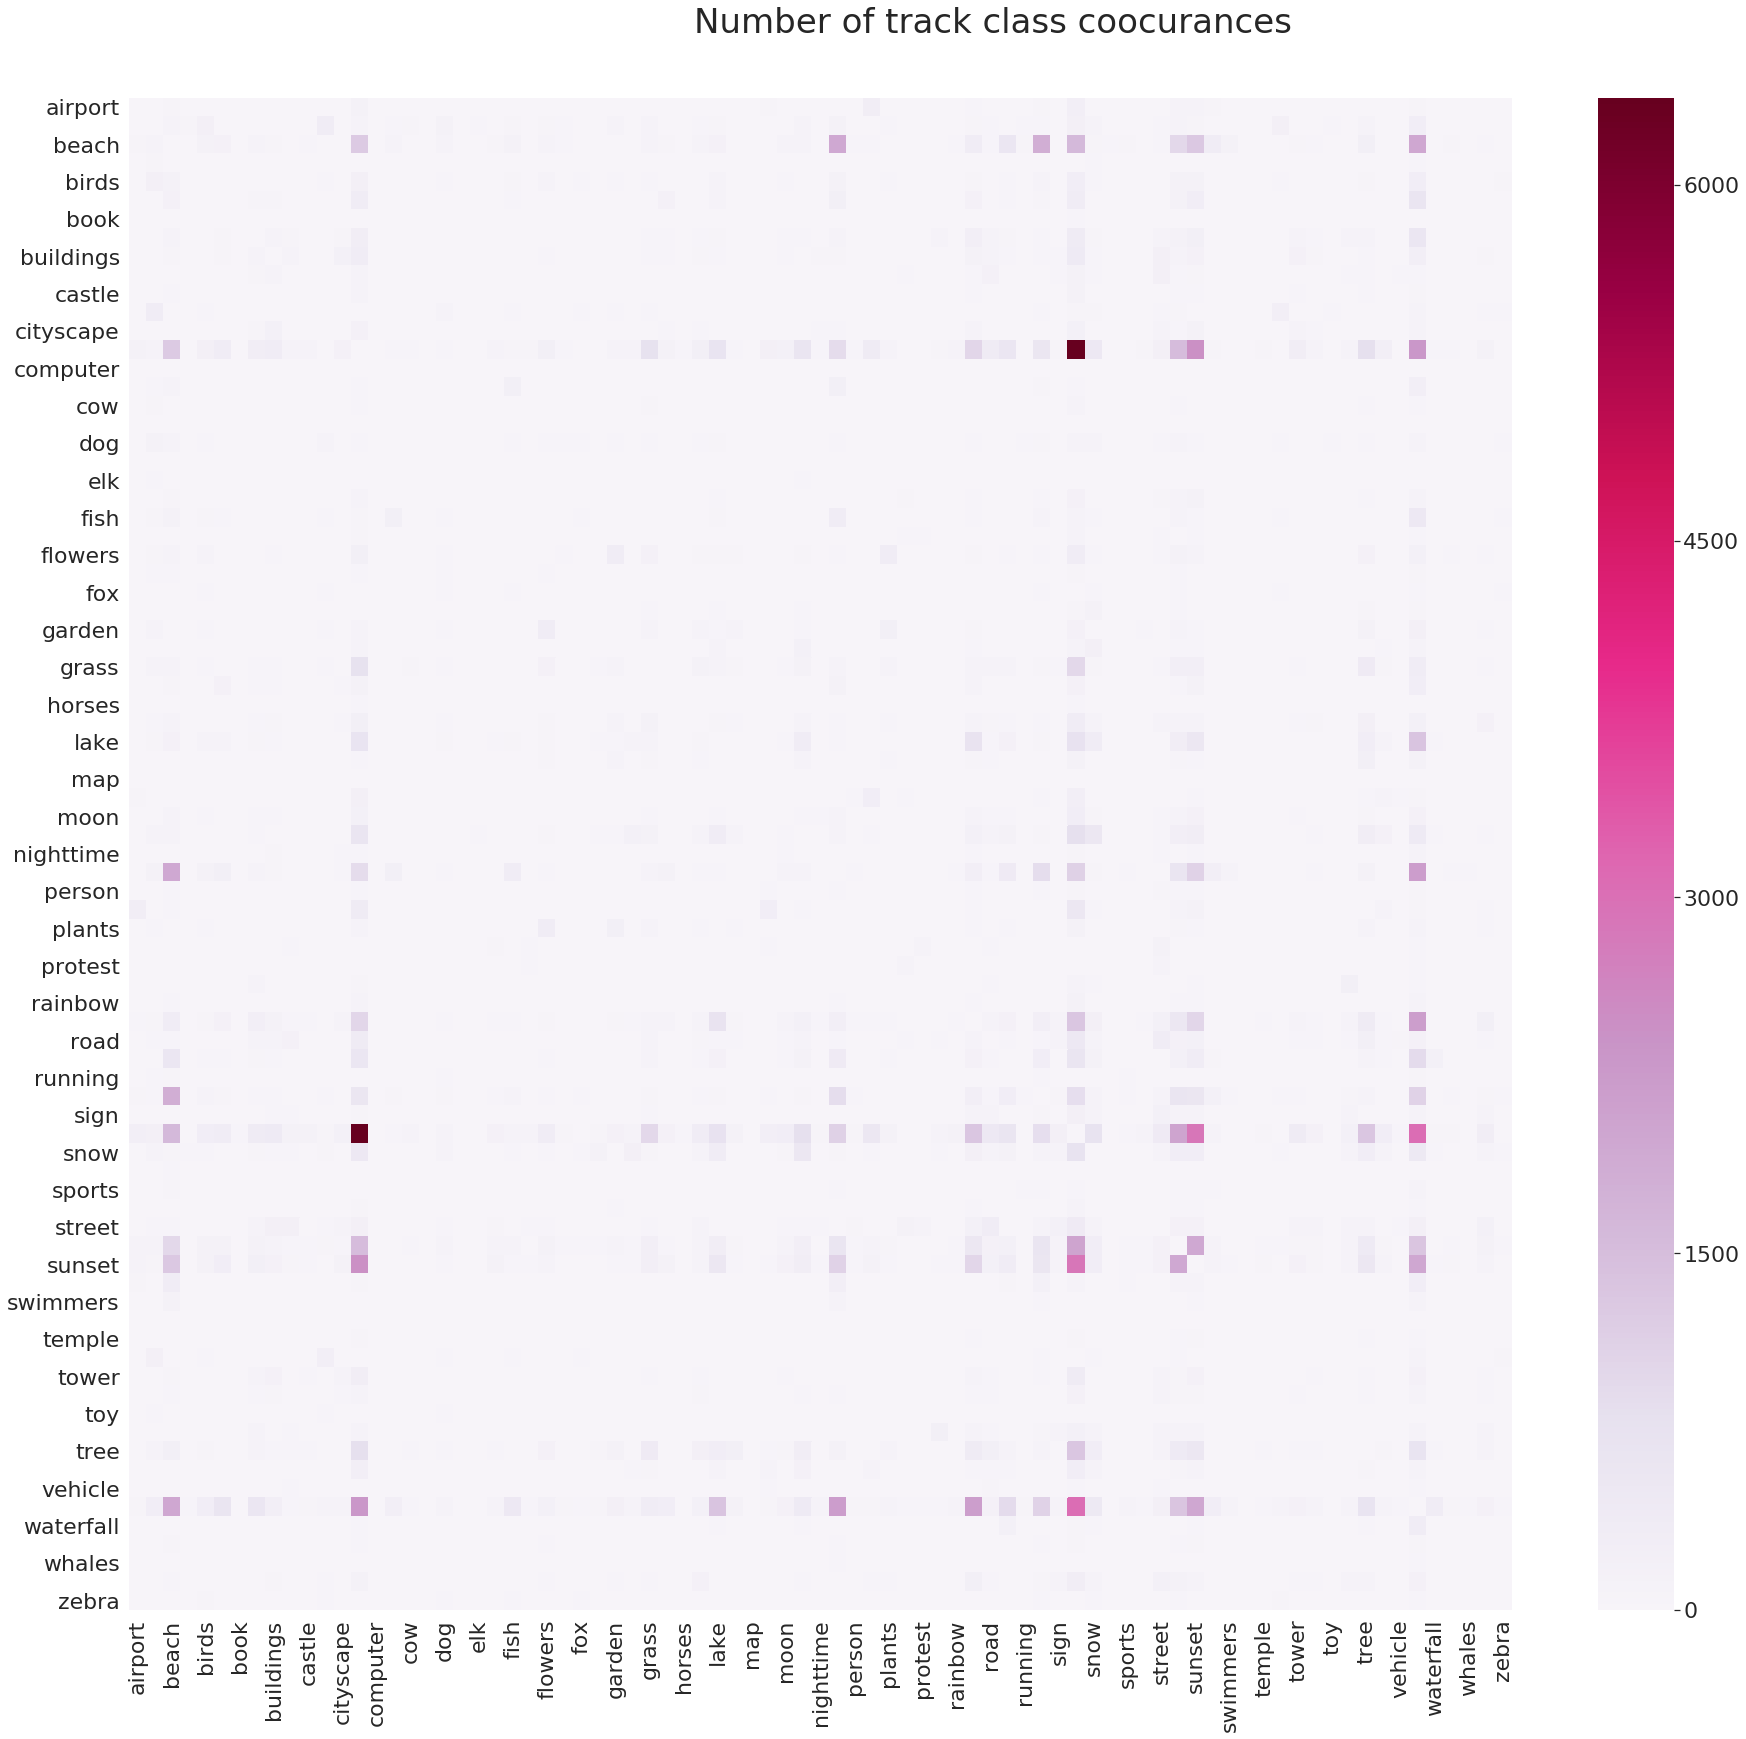

In [27]:
coocurrances, coocurrances_normalied = get_coocurances(labels)

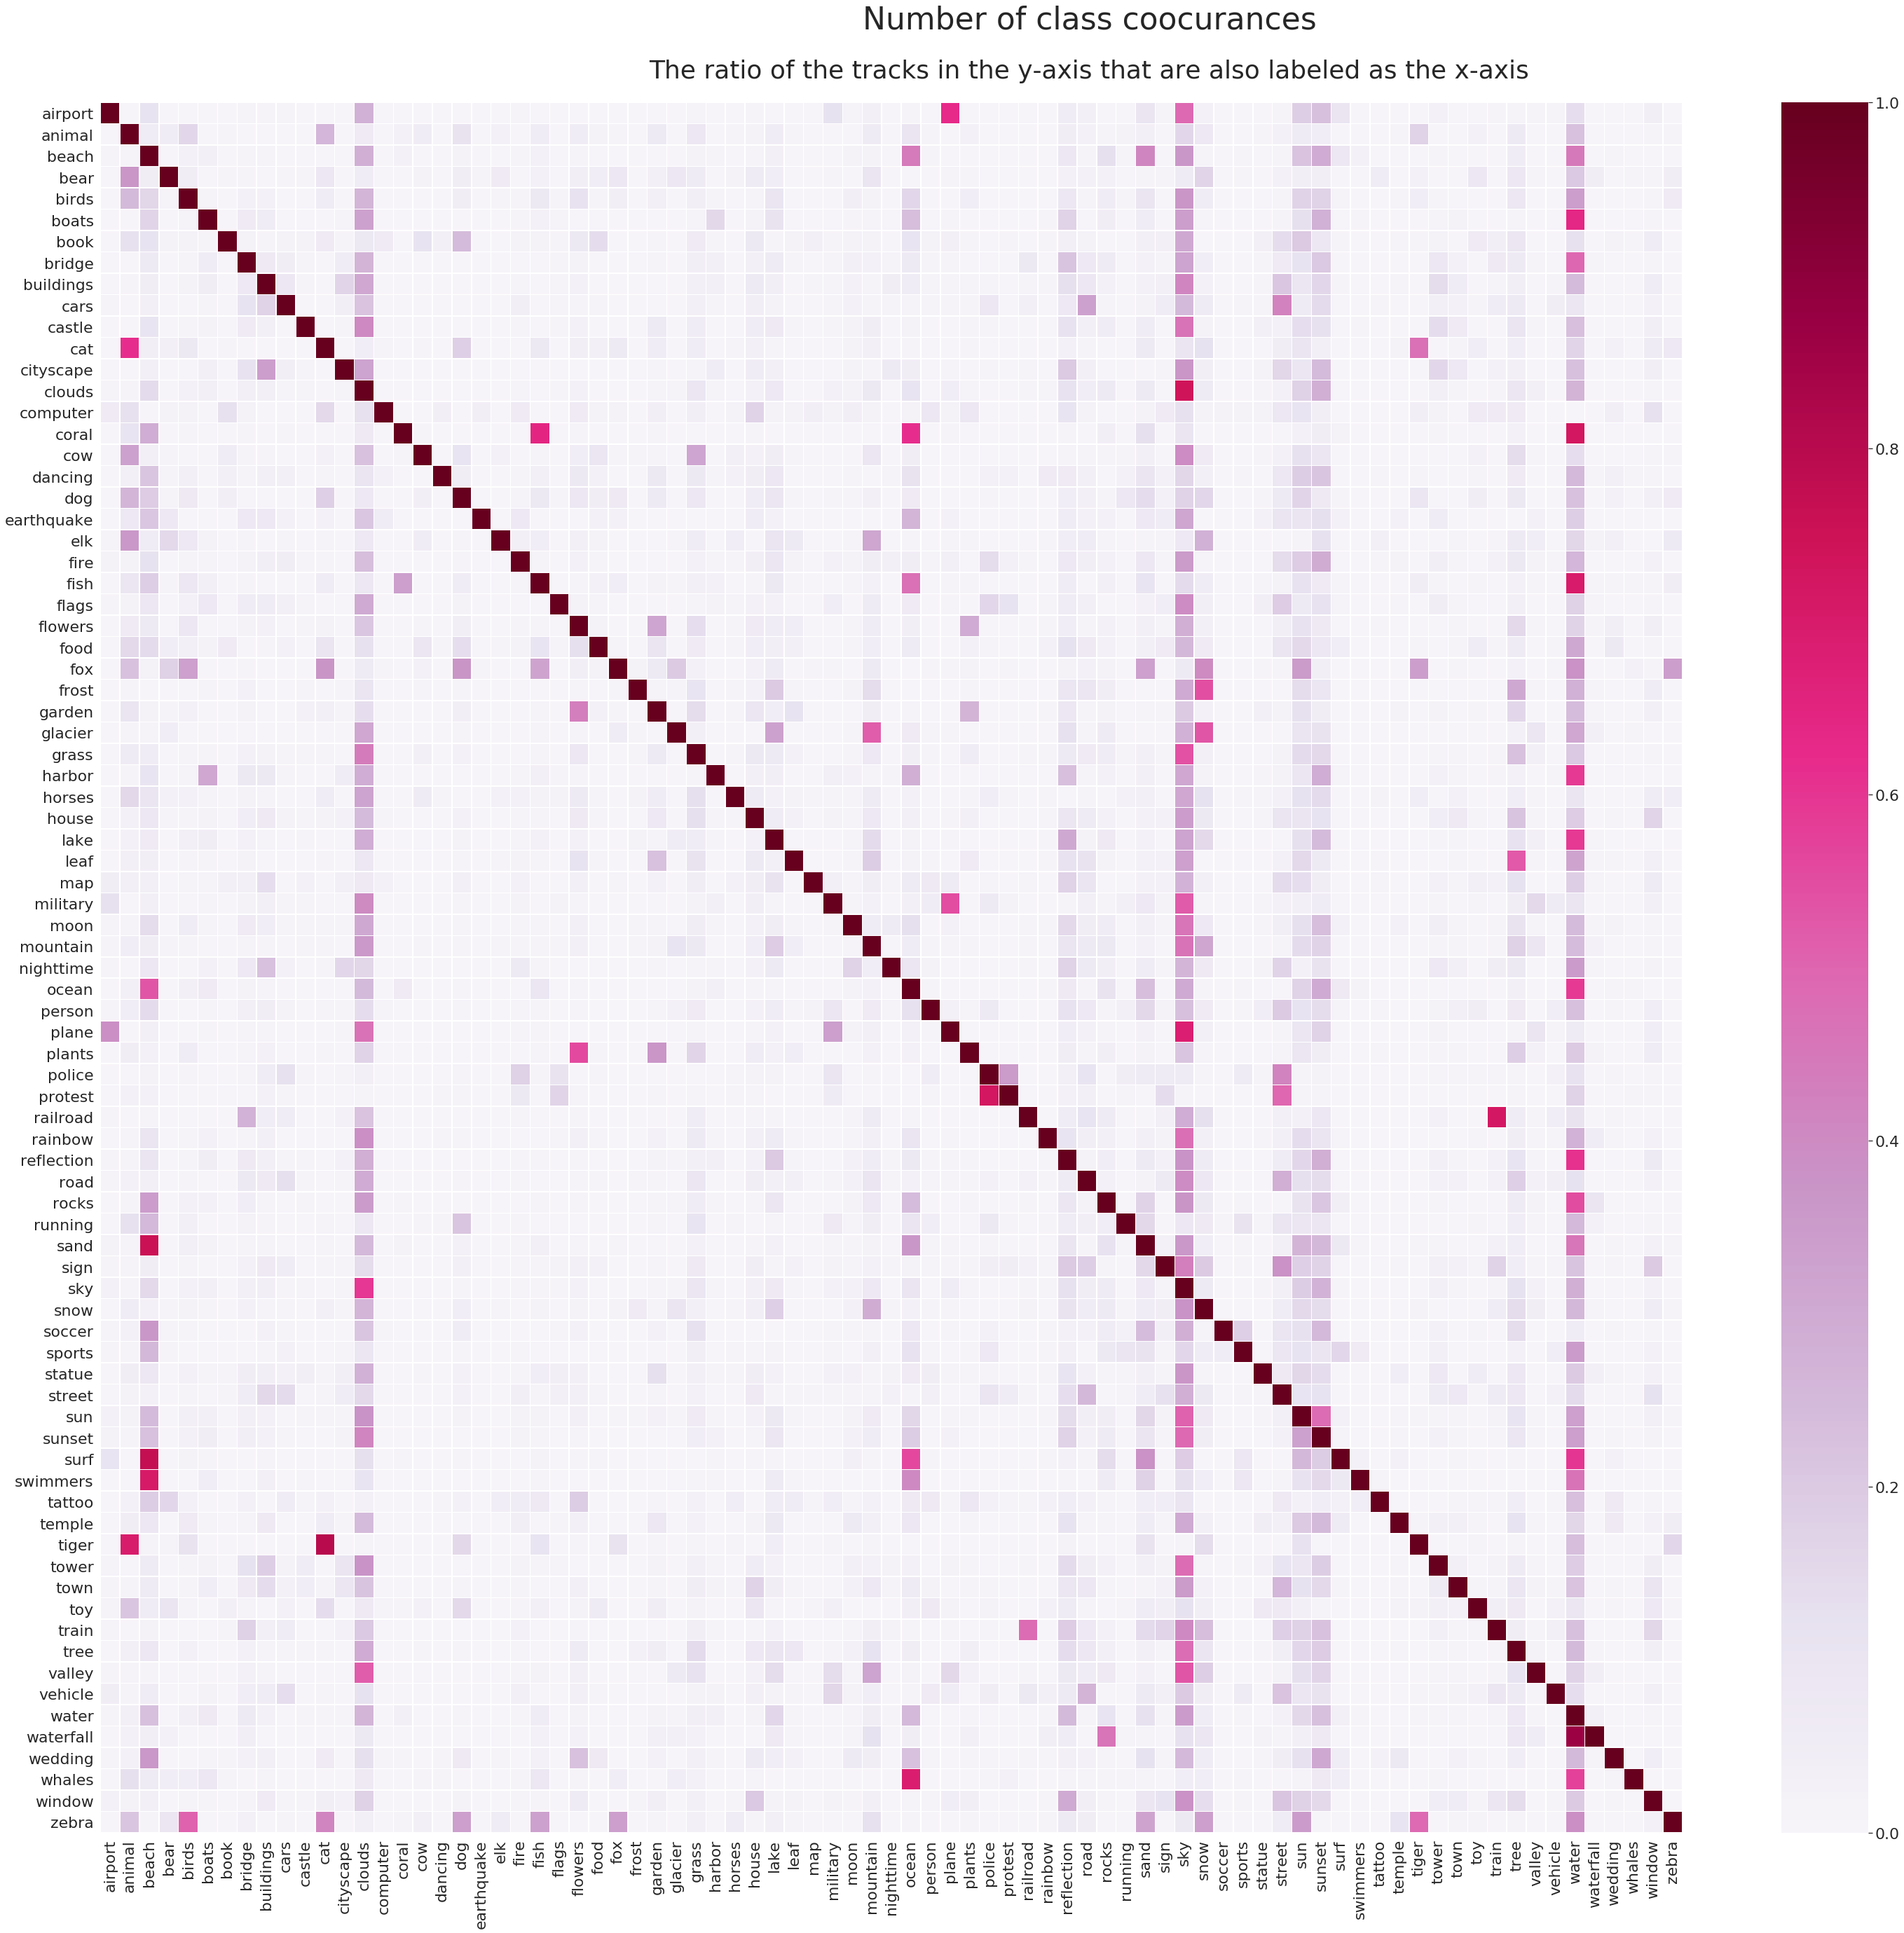

In [28]:
# Plotting coocurances normalized
plt.figure(figsize=(49, 49));
sn.set(font_scale=2)  # for label size
cmap = 'PuRd'
plt.axes([.1, .1, .8, .7])
plt.figtext(.5, .83, 'Number of class coocurances', fontsize=44, ha='center')
plt.figtext(.5,.81,'The ratio of the tracks in the y-axis that are also labeled as the x-axis',fontsize=36,ha='center')
sn.heatmap(coocurrances_normalied, annot=False, annot_kws={"size": 24}, fmt='.0f', cmap=cmap, linewidths=.5);